# CNN Posion Attack and Defense

#### Imports and Dependencies

In [1]:
import torch
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch import nn
import os
import numpy as np
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset
from tqdm import tqdm

from helper import print_accuracy

from torchvision.models import resnet50, ResNet50_Weights
from torch.utils.data.sampler import SubsetRandomSampler  #for validation test

%run models.ipynb

#### Setup the Device

In [2]:
# Check that MPS is available, if not, check if CUDA is available, if not, CPU
device = torch.device('cpu')
display_devices = False

if not torch.backends.mps.is_available():
    # If cuda is available...
    if torch.cuda.is_available():
        # Find GPU with most free memory and set that as the device
        mem_usage_list = [torch.cuda.mem_get_info(f'cuda:{gpu_num}')[0] for gpu_num in range(torch.cuda.device_count())]
        most_free = mem_usage_list.index(max(mem_usage_list))
        device = torch.device(f'cuda:{most_free}')
        print(f'Setting the device to {device}...\n')

        if display_devices:
            # Print GPU info on all
            for gpu_num in range(torch.cuda.device_count()):
                available_mem, total_mem = torch.cuda.mem_get_info(f'cuda:{gpu_num}')
                print(f'cuda:{gpu_num}')
                print('Memory Usage:')
                print('Total:', round(total_mem/1024**3,2), 'GB')
                print('Allocated:', round((total_mem-available_mem)/1024**3,2), 'GB')
                print('Free:   ', round(available_mem/1024**3,2), 'GB')
                print()
        # Set the default tensor type to gpu
        torch.set_default_tensor_type(torch.cuda.FloatTensor)
else:
    device = torch.device("mps")

Setting the device to cuda:1...



#### Constants

In [3]:
WORKING_DIR = os.getcwd()
# MODELS_PATH = os.path.join(WORKING_DIR, "models")
FEATURES_PATH = os.path.join(WORKING_DIR, "features")

# Check if the models directory exists, if not, create it
# if not os.path.exists(MODELS_PATH):
#     os.makedirs(MODELS_PATH)
if not os.path.exists(FEATURES_PATH):
    os.makedirs(FEATURES_PATH)

#### Load the Datasets

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.2859, 0.3530)
])

trainset = datasets.FashionMNIST('MNIST_data/', download = True, train = True, transform = transform)
testset = datasets.FashionMNIST('MNIST_data/', download = True, train = False, transform = transform)

# Preparing for validaion test
indices = list(range(len(trainset)))
np.random.shuffle(indices)
# to get 20% of the train set
split = int(np.floor(0.2 * len(trainset)))
valid_sample = SubsetRandomSampler(indices[:split])
train_sample = SubsetRandomSampler(indices[split:])

# Data Loader
trainloader = torch.utils.data.DataLoader(trainset, sampler=train_sample, batch_size=64, generator=torch.Generator(device))
validloader = torch.utils.data.DataLoader(trainset, sampler=valid_sample, batch_size=64, generator=torch.Generator(device))
testloader = torch.utils.data.DataLoader(testset, batch_size = 64, shuffle = True, generator=torch.Generator(device))

----
----

## Base Model

In [5]:
base_cnn_model = FashionCNN().to(device)
optimizer = torch.optim.Adam(base_cnn_model.parameters(), lr = 0.005)
criterion = nn.CrossEntropyLoss()
print(base_cnn_model)  # print model structure

FashionCNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=192, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (out): Linear(in_features=60, out_features=10, bias=True)
)


In [6]:
# Train the model
train_model(base_cnn_model, trainloader, validloader, optimizer, criterion, 10)
# Print the accuracy of the model
print_accuracy(base_cnn_model, testloader, device)

Training model...


100%|██████████| 750/750 [00:10<00:00, 69.83it/s]


Epoch: 1/10  Training loss: 0.5454  Validation loss: 0.4034  Validation accuracy: 0.8490


100%|██████████| 750/750 [00:08<00:00, 92.86it/s]


Epoch: 2/10  Training loss: 0.3806  Validation loss: 0.3500  Validation accuracy: 0.8673


100%|██████████| 750/750 [00:08<00:00, 92.50it/s]


Epoch: 3/10  Training loss: 0.3454  Validation loss: 0.3438  Validation accuracy: 0.8759


100%|██████████| 750/750 [00:08<00:00, 92.96it/s]


Epoch: 4/10  Training loss: 0.3256  Validation loss: 0.3471  Validation accuracy: 0.8716


100%|██████████| 750/750 [00:08<00:00, 87.51it/s]


Epoch: 5/10  Training loss: 0.3148  Validation loss: 0.3272  Validation accuracy: 0.8825


100%|██████████| 750/750 [00:08<00:00, 92.08it/s]


Epoch: 6/10  Training loss: 0.2952  Validation loss: 0.3218  Validation accuracy: 0.8798


100%|██████████| 750/750 [00:09<00:00, 83.15it/s]


Epoch: 7/10  Training loss: 0.2928  Validation loss: 0.3350  Validation accuracy: 0.8788


100%|██████████| 750/750 [00:07<00:00, 93.93it/s] 


Epoch: 8/10  Training loss: 0.2829  Validation loss: 0.3319  Validation accuracy: 0.8817


100%|██████████| 750/750 [00:07<00:00, 95.82it/s] 


Epoch: 9/10  Training loss: 0.2831  Validation loss: 0.3200  Validation accuracy: 0.8873


100%|██████████| 750/750 [00:08<00:00, 93.53it/s]


Epoch: 10/10  Training loss: 0.2697  Validation loss: 0.3503  Validation accuracy: 0.8807
Accuracy of T-shirt/Top: 85.40%
Accuracy of Trouser: 97.00%
Accuracy of Pullover: 85.00%
Accuracy of Dress: 85.50%
Accuracy of Coat: 81.20%
Accuracy of Sandal: 97.80%
Accuracy of Shirt: 60.40%
Accuracy of Sneaker: 96.50%
Accuracy of Bag: 97.10%
Accuracy of Ankle Boot: 92.60%


----

## Training with Poisoned Attack

- knowledge-oblivious–the attacker shall have no knowledge of the target model’s parameters/structures, nor the original training datasets, 

- cleanlabel–the attacker shall not be able to control the labeling process, and

- clean-test–test-time instances shall not be required to be modified using added adversarial perturbations for attacking effectiveness (https://www.ecva.net/papers/eccv_2020/papers_ECCV/papers/123720137.pdf)

In [6]:
class FashionDataset(Dataset):
    """User defined class to build a datset using Pytorch class Dataset."""

    def __init__(self, X, Y, transform = None):
        """Method to initilaize variables."""
        self.images = X
        self.labels = Y
        self.transform = transform

    def __getitem__(self, index):
        label = self.labels[index]
        image = self.images[index]
        if self.transform:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.images)

In [7]:
def create_poison_dataset(x_train, y_train, size_of_infected):
    # generate the infected random indices from the training sample
    generatePoisonIdx = np.random.choice(len(x_train), size=(size_of_infected,), replace=False)
    # generate normal indices excluding from the training sample
    trainIdx = np.array([i for i in range(len(x_train)) if i not in generatePoisonIdx])

    # indexing all the infected
    x_pois_train, y_pois_train = x_train[generatePoisonIdx], y_train[generatePoisonIdx]
    # indexing all the noromal
    x_train_new, y_train_new = x_train[trainIdx], y_train[trainIdx]

    # mix up the labels(infecting the infected)
    random_labels = np.random.randint(10, size=size_of_infected)
    y_pois_train = np.where(y_pois_train == y_pois_train, random_labels, y_pois_train)

    x_poison_train = np.concatenate((x_train_new, x_pois_train))
    y_poison_train = np.concatenate((y_train_new, y_pois_train))

    print("Training samples after infection : ", x_poison_train.shape)
    print("Labels samples after infection : ", y_poison_train.shape)

    return x_poison_train, y_poison_train

In [8]:
transform_new = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.2859, 0.3530)
])

x_poison_train, y_poison_train = create_poison_dataset(trainset.data, trainset.targets, 20000)

dataset = FashionDataset(x_poison_train, y_poison_train, transform_new)

# Preparing for validaion test
indices = list(range(len(dataset)))
np.random.shuffle(indices)

# to get 20% of the train set
split = int(np.floor(0.2 * len(dataset)))
valid_sample = SubsetRandomSampler(indices[:split])
train_sample = SubsetRandomSampler(indices[split:])

# Data Loader
poisoned_trainloader = torch.utils.data.DataLoader(dataset, sampler=train_sample, batch_size=64, generator=torch.Generator(device))
poisoned_validloader = torch.utils.data.DataLoader(dataset, sampler=valid_sample, batch_size=64, generator=torch.Generator(device))
testloader = torch.utils.data.DataLoader(testset, batch_size = 12, shuffle = True, generator=torch.Generator(device))

Training samples after infection :  (60000, 28, 28)
Labels samples after infection :  (60000,)


In [9]:
poisoned_cnn_model = FashionCNN().to(device)
optimizer = torch.optim.Adam(poisoned_cnn_model.parameters(), lr = 0.005)
criterion = nn.CrossEntropyLoss()
print(poisoned_cnn_model)  # print model structure

FashionCNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=192, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (out): Linear(in_features=60, out_features=10, bias=True)
)


In [11]:
# Train the model
train_model(
    poisoned_cnn_model, poisoned_trainloader, poisoned_validloader,
    optimizer, criterion, 10
)
# Print the accuracy of the model
print_accuracy(poisoned_cnn_model, testloader, device)

Training model...


100%|██████████| 750/750 [00:06<00:00, 123.48it/s]


Epoch: 1/10  Training loss: 1.6112  Validation loss: 1.5300  Validation accuracy: 0.5877


100%|██████████| 750/750 [00:05<00:00, 126.02it/s]


Epoch: 2/10  Training loss: 1.5117  Validation loss: 1.5039  Validation accuracy: 0.5960


100%|██████████| 750/750 [00:05<00:00, 132.76it/s]


Epoch: 3/10  Training loss: 1.4842  Validation loss: 1.4777  Validation accuracy: 0.6011


100%|██████████| 750/750 [00:05<00:00, 125.94it/s]


Epoch: 4/10  Training loss: 1.4692  Validation loss: 1.4798  Validation accuracy: 0.6062


100%|██████████| 750/750 [00:05<00:00, 125.49it/s]


Epoch: 5/10  Training loss: 1.4604  Validation loss: 1.4658  Validation accuracy: 0.6081


100%|██████████| 750/750 [00:06<00:00, 108.84it/s]


Epoch: 6/10  Training loss: 1.4545  Validation loss: 1.4702  Validation accuracy: 0.6042


100%|██████████| 750/750 [00:06<00:00, 118.99it/s]


Epoch: 7/10  Training loss: 1.4456  Validation loss: 1.4767  Validation accuracy: 0.6112


100%|██████████| 750/750 [00:05<00:00, 142.48it/s]


Epoch: 8/10  Training loss: 1.4420  Validation loss: 1.4701  Validation accuracy: 0.6073


100%|██████████| 750/750 [00:05<00:00, 134.07it/s]


Epoch: 9/10  Training loss: 1.4356  Validation loss: 1.4721  Validation accuracy: 0.6098


100%|██████████| 750/750 [00:05<00:00, 133.66it/s]


Epoch: 10/10  Training loss: 1.4344  Validation loss: 1.4784  Validation accuracy: 0.6049
Accuracy of T-shirt/Top: 68.80%
Accuracy of Trouser: 96.10%
Accuracy of Pullover: 76.40%
Accuracy of Dress: 89.10%
Accuracy of Coat: 70.50%
Accuracy of Sandal: 91.90%
Accuracy of Shirt: 63.10%
Accuracy of Sneaker: 95.80%
Accuracy of Bag: 97.30%
Accuracy of Ankle Boot: 94.00%


----
----

## Defenses

In [10]:
# For defense, we will not split the validation set
poisoned_full_trainloader = torch.utils.data.DataLoader(dataset, batch_size=64, generator=torch.Generator(device))
clean_full_trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, generator=torch.Generator(device))

### Clustering
Using Auto Encoders to cluster the poisoned data and find the labels/accuracy improvement.

In [13]:
%run clustering.ipynb

##### Clustering with Flattening
Simply flattening before clustering.

Flattening testing image: 100%|██████████| 834/834 [00:01<00:00, 771.07it/s]


Saving flattened data to disk...
Clustering the data...
Fashion MNIST - flat pca 10 Components - ACCURACY: 0.47246666666666665


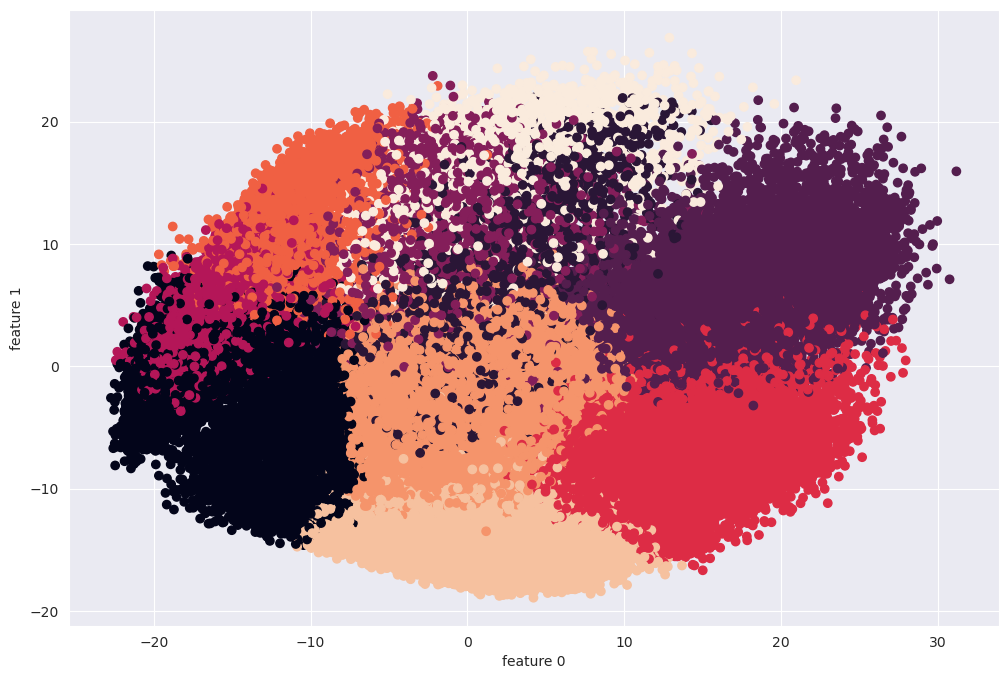

Clustering Accuracy PCA - Flatten Image (Train): 0.47246666666666665
Clustering Accuracy PCA - Flatten Image (Test): 0.4841

Loading flattened data from saved location...
Clustering the data...
Fashion MNIST - flat lda 10 Components - ACCURACY: 0.8207666666666666


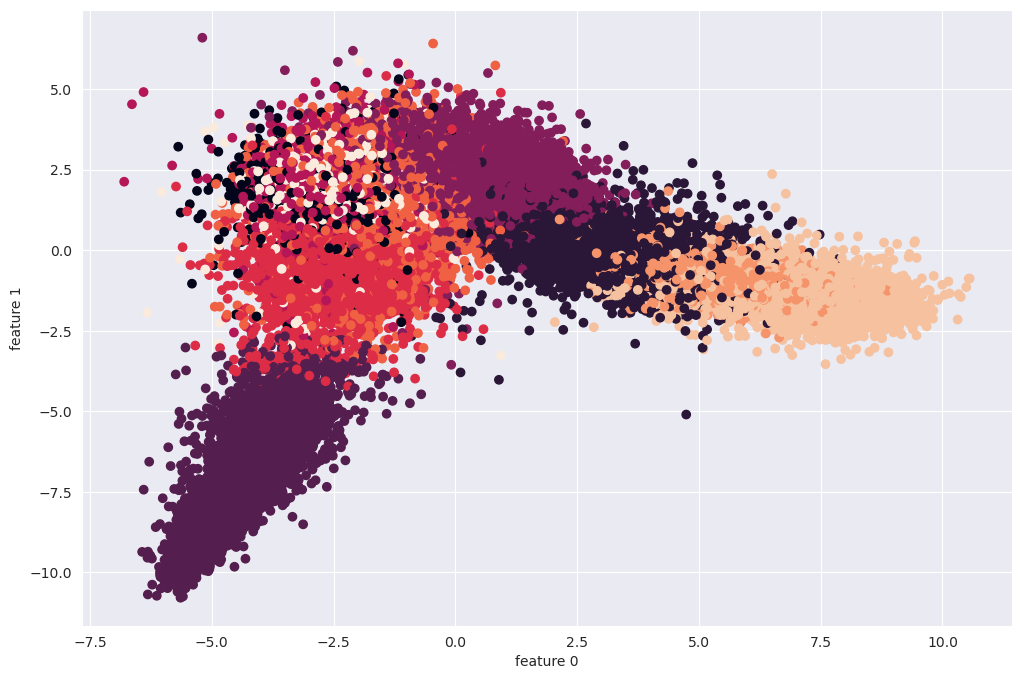

Clustering Accuracy LDA - Flatten Image (Train): 0.8207666666666666
Clustering Accuracy LDA - Flatten Image (Test): 0.8042


In [14]:
cae_flat_pca, train_flat_benchmark_pca, test_flat_benchmark_pca = train_cluster(clean_full_trainloader, clean_full_trainloader, testloader, "flat", "pca", device, FEATURES_PATH, 10)
print(f"Clustering Accuracy PCA - Flatten Image (Train): {train_flat_benchmark_pca[1]['clustering_accuracy']}")
print(f"Clustering Accuracy PCA - Flatten Image (Test): {test_flat_benchmark_pca[1]['clustering_accuracy']}")
print()
cae_flat_lda, train_flat_benchmark_lda, test_flat_benchmark_lda = train_cluster(clean_full_trainloader, clean_full_trainloader, testloader, "flat", "lda", device, FEATURES_PATH, 10)
print(f"Clustering Accuracy LDA - Flatten Image (Train): {train_flat_benchmark_lda[1]['clustering_accuracy']}")
print(f"Clustering Accuracy LDA - Flatten Image (Test): {test_flat_benchmark_lda[1]['clustering_accuracy']}")

##### Clustering with Feature Extraction
Use VGG16 to extract features from images before clustering.

Retrieve testing image features: 100%|██████████| 834/834 [00:04<00:00, 201.57it/s]


Saving feature data to disk...
Clustering the data...
Fashion MNIST - feature pca 10 Components - ACCURACY: 0.5493333333333333


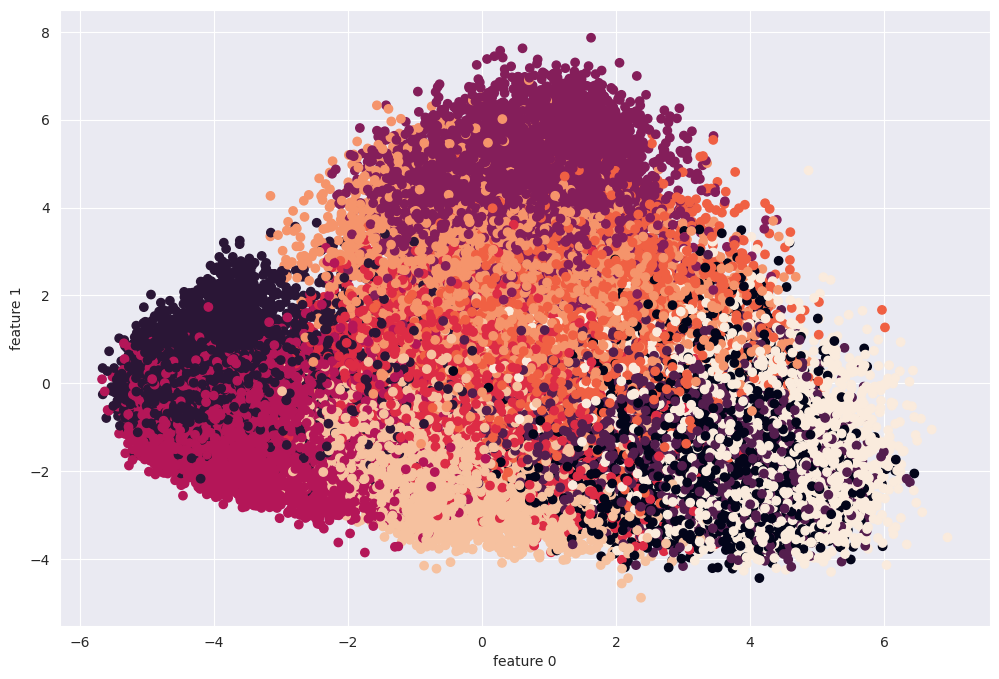

Clustering Accuracy PCA - Feature Image (Train): 0.5493333333333333
Clustering Accuracy PCA - Feature Image (Test): 0.545

Loading feature data from saved location...
Clustering the data...
Fashion MNIST - feature lda 10 Components - ACCURACY: 0.8426333333333333


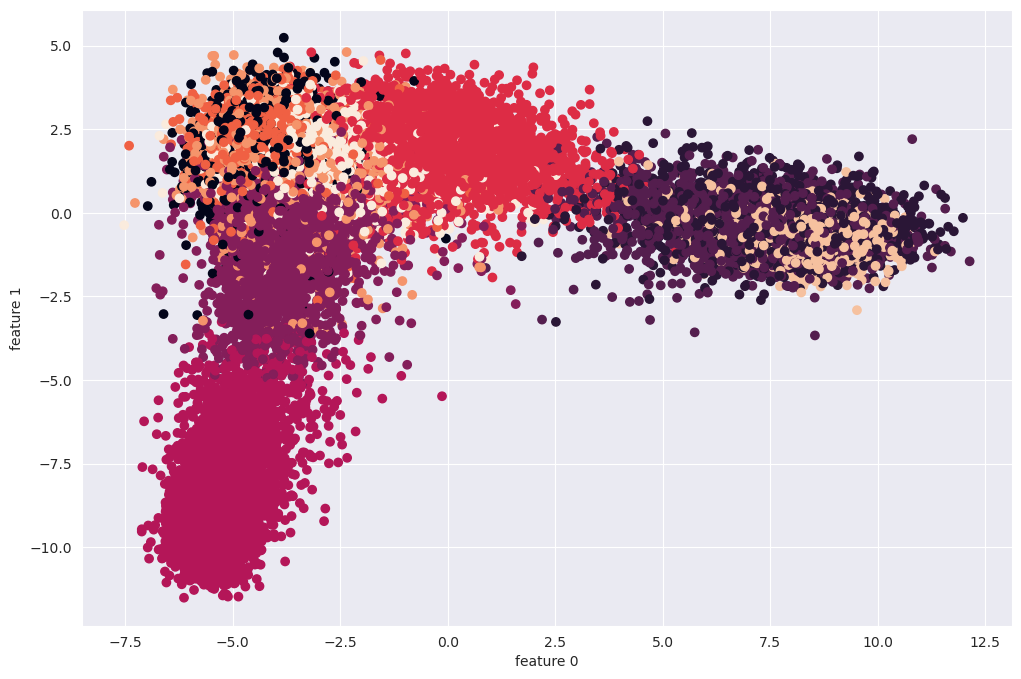

Clustering Accuracy LDA - Feature Image (Train): 0.8426333333333333
Clustering Accuracy LDA - Feature Image (Test): 0.835


In [15]:
cae_feature_pca, train_feature_benchmark_pca, test_feature_benchmark_pca = train_cluster(clean_full_trainloader, clean_full_trainloader, testloader, "feature", "pca", device, FEATURES_PATH, 10)
print(f"Clustering Accuracy PCA - Feature Image (Train): {train_feature_benchmark_pca[1]['clustering_accuracy']}")
print(f"Clustering Accuracy PCA - Feature Image (Test): {test_feature_benchmark_pca[1]['clustering_accuracy']}")
print()
cae_feature_lda, train_feature_benchmark_lda, test_feature_benchmark_lda = train_cluster(clean_full_trainloader, clean_full_trainloader, testloader, "feature", "lda", device, FEATURES_PATH, 10)
print(f"Clustering Accuracy LDA - Feature Image (Train): {train_feature_benchmark_lda[1]['clustering_accuracy']}")
print(f"Clustering Accuracy LDA - Feature Image (Test): {test_feature_benchmark_lda[1]['clustering_accuracy']}")

### Emsemble Learning
Using multiple smaller models to train on the poisoned dataset. The mean accuracy of the models can represent the true accuracy.

In [13]:
%run ensemble.ipynb

In [17]:
avg_train_loss, avg_valid_loss, avg_valid_acc = train_split_models(dataset, epochs=10, n_splits=5)

Training model...


100%|██████████| 150/150 [00:01<00:00, 114.95it/s]


Epoch: 1/10  Training loss: 1.7716  Validation loss: 1.6061  Validation accuracy: 0.5304


100%|██████████| 150/150 [00:01<00:00, 139.28it/s]


Epoch: 2/10  Training loss: 1.5994  Validation loss: 1.5883  Validation accuracy: 0.5492


100%|██████████| 150/150 [00:01<00:00, 127.71it/s]


Epoch: 3/10  Training loss: 1.5545  Validation loss: 1.5632  Validation accuracy: 0.5721


100%|██████████| 150/150 [00:01<00:00, 136.58it/s]


Epoch: 4/10  Training loss: 1.5241  Validation loss: 1.5226  Validation accuracy: 0.5904


100%|██████████| 150/150 [00:01<00:00, 138.63it/s]


Epoch: 5/10  Training loss: 1.4911  Validation loss: 1.5450  Validation accuracy: 0.5883


100%|██████████| 150/150 [00:01<00:00, 140.14it/s]


Epoch: 6/10  Training loss: 1.4684  Validation loss: 1.5108  Validation accuracy: 0.5925


100%|██████████| 150/150 [00:01<00:00, 142.80it/s]


Epoch: 7/10  Training loss: 1.4530  Validation loss: 1.5497  Validation accuracy: 0.5958


100%|██████████| 150/150 [00:01<00:00, 134.91it/s]


Epoch: 8/10  Training loss: 1.4298  Validation loss: 1.5542  Validation accuracy: 0.5908


100%|██████████| 150/150 [00:01<00:00, 137.06it/s]


Epoch: 9/10  Training loss: 1.4075  Validation loss: 1.5993  Validation accuracy: 0.5929


100%|██████████| 150/150 [00:01<00:00, 141.19it/s]


Epoch: 10/10  Training loss: 1.3834  Validation loss: 1.5735  Validation accuracy: 0.5904
Training model...


100%|██████████| 150/150 [00:01<00:00, 137.30it/s]


Epoch: 1/10  Training loss: 1.7500  Validation loss: 1.5935  Validation accuracy: 0.5254


100%|██████████| 150/150 [00:01<00:00, 139.21it/s]


Epoch: 2/10  Training loss: 1.5916  Validation loss: 1.5798  Validation accuracy: 0.5525


100%|██████████| 150/150 [00:01<00:00, 138.01it/s]


Epoch: 3/10  Training loss: 1.5587  Validation loss: 1.5401  Validation accuracy: 0.5708


100%|██████████| 150/150 [00:01<00:00, 138.82it/s]


Epoch: 4/10  Training loss: 1.5265  Validation loss: 1.5607  Validation accuracy: 0.5771


100%|██████████| 150/150 [00:01<00:00, 139.82it/s]


Epoch: 5/10  Training loss: 1.5063  Validation loss: 1.5190  Validation accuracy: 0.5850


100%|██████████| 150/150 [00:01<00:00, 137.91it/s]


Epoch: 6/10  Training loss: 1.4693  Validation loss: 1.5095  Validation accuracy: 0.5842


100%|██████████| 150/150 [00:01<00:00, 127.74it/s]


Epoch: 7/10  Training loss: 1.4513  Validation loss: 1.5143  Validation accuracy: 0.5962


100%|██████████| 150/150 [00:01<00:00, 141.86it/s]


Epoch: 8/10  Training loss: 1.4200  Validation loss: 1.5092  Validation accuracy: 0.5954


100%|██████████| 150/150 [00:01<00:00, 139.54it/s]


Epoch: 9/10  Training loss: 1.4028  Validation loss: 1.5553  Validation accuracy: 0.5896


100%|██████████| 150/150 [00:01<00:00, 133.02it/s]


Epoch: 10/10  Training loss: 1.3765  Validation loss: 1.5676  Validation accuracy: 0.5879
Training model...


100%|██████████| 150/150 [00:01<00:00, 132.39it/s]


Epoch: 1/10  Training loss: 1.7313  Validation loss: 1.5645  Validation accuracy: 0.5479


100%|██████████| 150/150 [00:01<00:00, 135.37it/s]


Epoch: 2/10  Training loss: 1.5932  Validation loss: 1.5550  Validation accuracy: 0.5658


100%|██████████| 150/150 [00:01<00:00, 136.08it/s]


Epoch: 3/10  Training loss: 1.5448  Validation loss: 1.5859  Validation accuracy: 0.5646


100%|██████████| 150/150 [00:01<00:00, 134.32it/s]


Epoch: 4/10  Training loss: 1.5189  Validation loss: 1.5369  Validation accuracy: 0.5654


100%|██████████| 150/150 [00:01<00:00, 134.13it/s]


Epoch: 5/10  Training loss: 1.4929  Validation loss: 1.5441  Validation accuracy: 0.5867


100%|██████████| 150/150 [00:01<00:00, 134.42it/s]


Epoch: 6/10  Training loss: 1.4728  Validation loss: 1.5236  Validation accuracy: 0.5683


100%|██████████| 150/150 [00:01<00:00, 140.38it/s]


Epoch: 7/10  Training loss: 1.4546  Validation loss: 1.5074  Validation accuracy: 0.5962


100%|██████████| 150/150 [00:01<00:00, 140.81it/s]


Epoch: 8/10  Training loss: 1.4265  Validation loss: 1.4990  Validation accuracy: 0.5933


100%|██████████| 150/150 [00:01<00:00, 135.87it/s]


Epoch: 9/10  Training loss: 1.4036  Validation loss: 1.5233  Validation accuracy: 0.5938


100%|██████████| 150/150 [00:01<00:00, 136.21it/s]


Epoch: 10/10  Training loss: 1.3971  Validation loss: 1.5270  Validation accuracy: 0.5958
Training model...


100%|██████████| 150/150 [00:01<00:00, 137.76it/s]


Epoch: 1/10  Training loss: 1.7311  Validation loss: 1.5918  Validation accuracy: 0.5537


100%|██████████| 150/150 [00:01<00:00, 132.73it/s]


Epoch: 2/10  Training loss: 1.5701  Validation loss: 1.5601  Validation accuracy: 0.5742


100%|██████████| 150/150 [00:01<00:00, 134.77it/s]


Epoch: 3/10  Training loss: 1.5325  Validation loss: 1.5476  Validation accuracy: 0.5742


100%|██████████| 150/150 [00:01<00:00, 110.39it/s]


Epoch: 4/10  Training loss: 1.4971  Validation loss: 1.5373  Validation accuracy: 0.5821


100%|██████████| 150/150 [00:01<00:00, 125.55it/s]


Epoch: 5/10  Training loss: 1.4705  Validation loss: 1.5003  Validation accuracy: 0.6021


100%|██████████| 150/150 [00:01<00:00, 133.11it/s]


Epoch: 6/10  Training loss: 1.4524  Validation loss: 1.5101  Validation accuracy: 0.6029


100%|██████████| 150/150 [00:01<00:00, 134.21it/s]


Epoch: 7/10  Training loss: 1.4275  Validation loss: 1.5068  Validation accuracy: 0.5971


100%|██████████| 150/150 [00:01<00:00, 134.80it/s]


Epoch: 8/10  Training loss: 1.4048  Validation loss: 1.5451  Validation accuracy: 0.5933


100%|██████████| 150/150 [00:01<00:00, 133.89it/s]


Epoch: 9/10  Training loss: 1.3773  Validation loss: 1.5810  Validation accuracy: 0.6012


100%|██████████| 150/150 [00:01<00:00, 135.21it/s]


Epoch: 10/10  Training loss: 1.3491  Validation loss: 1.5537  Validation accuracy: 0.5979
Training model...


100%|██████████| 150/150 [00:01<00:00, 133.94it/s]


Epoch: 1/10  Training loss: 1.7734  Validation loss: 1.5970  Validation accuracy: 0.5104


100%|██████████| 150/150 [00:01<00:00, 126.56it/s]


Epoch: 2/10  Training loss: 1.6099  Validation loss: 1.5689  Validation accuracy: 0.5517


100%|██████████| 150/150 [00:01<00:00, 135.30it/s]


Epoch: 3/10  Training loss: 1.5602  Validation loss: 1.5818  Validation accuracy: 0.5704


100%|██████████| 150/150 [00:01<00:00, 136.21it/s]


Epoch: 4/10  Training loss: 1.5194  Validation loss: 1.5155  Validation accuracy: 0.5833


100%|██████████| 150/150 [00:01<00:00, 135.76it/s]


Epoch: 5/10  Training loss: 1.4912  Validation loss: 1.4992  Validation accuracy: 0.5908


100%|██████████| 150/150 [00:01<00:00, 134.84it/s]


Epoch: 6/10  Training loss: 1.4774  Validation loss: 1.5423  Validation accuracy: 0.5833


100%|██████████| 150/150 [00:01<00:00, 133.03it/s]


Epoch: 7/10  Training loss: 1.4452  Validation loss: 1.5236  Validation accuracy: 0.5917


100%|██████████| 150/150 [00:01<00:00, 133.26it/s]


Epoch: 8/10  Training loss: 1.4309  Validation loss: 1.5599  Validation accuracy: 0.5800


100%|██████████| 150/150 [00:01<00:00, 136.72it/s]


Epoch: 9/10  Training loss: 1.4065  Validation loss: 1.5284  Validation accuracy: 0.5975


100%|██████████| 150/150 [00:01<00:00, 136.71it/s]


Epoch: 10/10  Training loss: 1.3805  Validation loss: 1.5891  Validation accuracy: 0.5913


In [18]:
print(f"Total Avg Train Loss: {avg_train_loss}")
print(f"Total Avg Valid Loss: {avg_valid_loss}")
print(f"Total Avg Valid Acc: {avg_valid_acc}")

Total Avg Train Loss: 1.3773389662106832
Total Avg Valid Loss: 1.5621660872509604
Total Avg Valid Acc: 0.5926666666666667
